In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pyodbc
from string import ascii_lowercase

In [2]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                            'SERVER=L_AAGDATIX;'
                            'DATABASE=DatixCRM;'
                            'Trusted_Connection=yes') 
query = "set transaction isolation level read uncommitted select b.description, c.description from DatixCRM.dbo.code_unit b join DatixCRM.dbo.incidents_main a on a.inc_unit = b.code join DatixCRM.dbo.code_locactual c on a.inc_locactual = c.code where a.inc_type='PAT' and a.inc_category='MEDIC' and a.inc_organisation='QA' and c.cod_parent2='QA'"
df = pd.read_sql(query, sql_conn)
df.columns = ['division-care_group','location']
df.head()

,division-care_group,location
0,"Clinical Delivery Division - Critical Care, Th...",Department of Critical Care (E5) (DCCQ)
1,"Clinical Delivery Division - Critical Care, Th...",Department of Critical Care (E5) (DCCQ)
2,"Clinical Delivery Division - Critical Care, Th...",Theatres QA
3,"Clinical Delivery Division - Critical Care, Th...",Department of Critical Care (E5) (DCCQ)
4,"Clinical Delivery Division - Critical Care, Th...",Department of Critical Care (E5) (DCCQ)


In [3]:
df['division-care_group'] = df['division-care_group'].str.replace(' and ',' & ')
divider = df['division-care_group'].str.split(" Division - ",n=1,expand=True)
df['division'] = divider[0]
df['care_group'] = divider[1]
#df['division'] = df['division'].str.replace(' and ',' & ')
df.loc[df.division == 'Corporate Functions', 'care_group'] = 'Corporate Functions'
df = df[df['division-care_group'] != 'Corporate Functions']
df = df[df.care_group != 'Pathology']
#df.loc[df.division == 'Surgical & Outpatients', 'division'] = 'Surgical & Outpatients + Corporate Functions'
#df.loc[df.division == 'Corporate Functions', 'division'] = 'Surgical & Outpatients + Corporate Functions'

In [4]:
division_counts = df['division'].value_counts()
division_percentages = 100*division_counts/sum(division_counts.values)
division_labels = [str(i) for i in division_counts.index]
print(division_percentages)

Medicine & Urgent Care    45.602241
Networked Services        20.605042
Surgical & Outpatients    16.918768
Clinical Delivery         16.873950
Name: division, dtype: float64


In [5]:
df['division_sorted'] = pd.Categorical(df['division'], division_labels)
df = df.sort_values("division_sorted")
df.head()

,division-care_group,location,division,care_group,division_sorted
4483,Medicine & Urgent Care Division - Urgent Care,Acute Medical Unit (AMU) (MAU),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care
3387,Medicine & Urgent Care Division - Older Person...,F4 Acute Stroke Ward,Medicine & Urgent Care,Older Persons Medicine,Medicine & Urgent Care
3386,Medicine & Urgent Care Division - Older Person...,F1 Neuro Rehab,Medicine & Urgent Care,Older Persons Medicine,Medicine & Urgent Care
3385,Medicine & Urgent Care Division - Older Person...,G1,Medicine & Urgent Care,Older Persons Medicine,Medicine & Urgent Care
3384,Medicine & Urgent Care Division - Older Person...,F1 Neuro Rehab,Medicine & Urgent Care,Older Persons Medicine,Medicine & Urgent Care


In [6]:
care_group_labels = []
for i in division_counts.index:
    df_division = df[df.division == i]
    per_division_counts = df_division['care_group'].value_counts()
    care_group_labels += [str(i) for i in per_division_counts.index]
print(care_group_labels)

['Urgent Care', 'Medicine', 'Older Persons Medicine', "Women & Children's", 'Regional Cancer Centre', 'Renal & Transplantation', 'MSK / Head & Neck', 'Surgery', 'Pharmacy', 'Critical Care, Theatres, Anaesthetics & HSDU', 'Imaging Radiology']


In [7]:
df['care_group_sorted'] = pd.Categorical(df['care_group'], care_group_labels)
df = df.sort_values(['division_sorted','care_group_sorted'])
df.head()

,division-care_group,location,division,care_group,division_sorted,care_group_sorted
4483,Medicine & Urgent Care Division - Urgent Care,Acute Medical Unit (AMU) (MAU),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care
3466,Medicine & Urgent Care Division - Urgent Care,Emergency Department (ED),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care
3465,Medicine & Urgent Care Division - Urgent Care,Emergency Department (ED),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care
3464,Medicine & Urgent Care Division - Urgent Care,Acute Medical Unit (AMU) (MAU),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care
3463,Medicine & Urgent Care Division - Urgent Care,Acute Medical Unit (AMU) (MAU),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care


In [8]:
care_group_counts = df['care_group'].value_counts()[df['care_group'].unique()]
care_group_percentages = 100*care_group_counts/sum(care_group_counts.values)
print(care_group_percentages)

Urgent Care                                     19.092437
Medicine                                        17.568627
Older Persons Medicine                           8.941176
Women & Children's                              10.039216
Regional Cancer Centre                           7.014006
Renal & Transplantation                          3.551821
MSK / Head & Neck                                9.591036
Surgery                                          7.327731
Pharmacy                                        11.686275
Critical Care, Theatres, Anaesthetics & HSDU     4.257703
Imaging Radiology                                0.929972
Name: care_group, dtype: float64


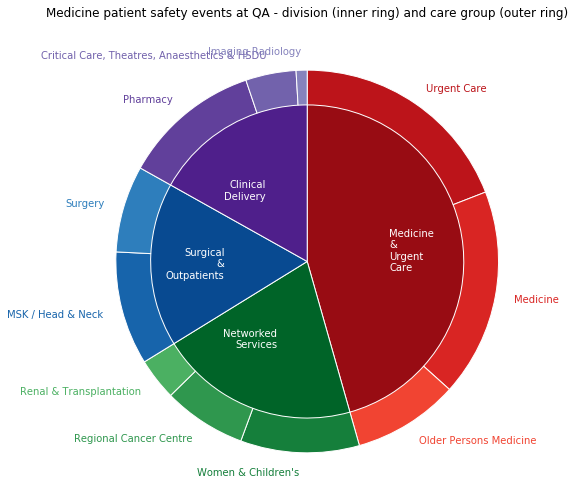

In [9]:
# Create colors
a, b, c, d, e =[plt.cm.Reds, plt.cm.Oranges, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]
a, c, d, e = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]
inner_ring_colours = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]

# First Ring (Inside)
fig, ax = plt.subplots()
ax.axis('equal')
division_labels_newlines = [i.replace(' ','\n') for i in division_labels]
#mypie, _ = ax.pie(division_counts, radius=2, labels=division_labels_newlines, labeldistance=0.6, colors=[a(0.9), b(0.9), c(0.9), d(0.9), e(0.9)], textprops={'color':'w'})
mypie, _ = ax.pie(division_counts, radius=1.9, labels=division_labels_newlines, labeldistance=0.5, colors=[inner_ring_colours[0](0.9), c(0.9), d(0.9), e(0.9)], textprops={'color':'w'}, startangle=90, counterclock=False)
plt.setp( mypie, width=1.9, edgecolor='white')
 
# Second Ring (oUTside)
#care_group_colours = [a(0.8), a(0.7), a(0.6), a(0.5), b(0.8), c(0.8), c(0.7), c(0.6), d(0.8), d(0.7), d(0.6), e(0.8), e(0.7), e(0.6)]
care_group_colours = []
for i,index in enumerate(division_counts.index):
    df_division = df[df.division == index]
    per_division_counts = df_division['care_group'].value_counts()
    slice_colour = 8
    for j in range(len(per_division_counts)):
        care_group_colours.append(inner_ring_colours[i](slice_colour/10))
        slice_colour -= 1

mypie2, texts = ax.pie(care_group_counts, radius=2.2, labels=care_group_labels, colors=care_group_colours, startangle=90, counterclock=False)
plt.setp( mypie2, width=0.4, edgecolor='white')
for text, color in zip(texts, care_group_colours):
    text.set_color(color)
plt.margins(0,0)

plt.title('Medicine patient safety events at QA - division (inner ring) and care group (outer ring)', y=1.6);

In [10]:
df.loc[df.location == 'Department of Critical Care (E5) (DCCQ)', 'location'] = 'E5'
df.loc[df.location == 'Acute Medical Unit (AMU) (MAU)', 'location'] = 'AMU'
df.loc[df.location == 'Haematology & Oncology Day Unit (HODU)', 'location'] = 'HODU'
df.loc[df.location == 'Childrens Assesment Unit (CAU)', 'location'] = 'CAU'
df.loc[df.location == 'Hepatology Clinic (Nurse led) (on C5)', 'location'] = 'Hepatology'
df.loc[df.location == 'Cardiac Day Unit (CDU)', 'location'] = 'CDU'
df.loc[df.location == 'Surgical Assessment Unit (SAU)', 'location'] = 'SAU'
df.location = df.location.str.replace(' QA','')
df.location = df.location.str.replace(' Department','')
df.location = df.location.str.replace(' Unit','')
df.location = df.location.str.replace(' Centre','')
df.location = df.location.str.replace(' Clinic','')
df.location = df.location.str.replace(' and ',' & ')
df.loc[df.location == 'Theatre Admissions Suite (TAS)', 'location'] = 'TAS'
df.loc[df.location == 'Pre-Operative Assessment (POA)', 'location'] = 'POA'
df.loc[df.location == 'Theatre - D1', 'location'] = 'D1'
df.loc[df.location == 'Research & Development', 'location'] = 'R&D'
df.loc[df.location == 'Reception (Atrium)', 'location'] = 'Reception'
df.loc[df.location == 'G5 Endoscopy Suites', 'location'] = 'G5'
df.loc[df.location == 'F3 Stroke Rehabilitation', 'location'] = 'F3'
df.loc[df.location == 'F4 Acute Stroke Ward', 'location'] = 'F4'
df.loc[df.location == 'F1  Neuro Rehab', 'location'] = 'F1'
df.loc[df.location == 'Emergency (ED)', 'location'] = 'ED'
df.loc[df.location == 'B6  Antenatal Ward', 'location'] = 'B6'
df.loc[df.location == 'B7 Postnatal Ward', 'location'] = 'B7'
df.loc[df.location == 'B9 NICU', 'location'] = 'B9'
df.loc[df.location == 'A7 Starfish', 'location'] = 'A7'
df.loc[df.location == 'A8 Shipwreck', 'location'] = 'A8'
df.loc[df.location == 'B5  - Mary Rose Ward', 'location'] = 'B5'
df.loc[df.location == 'B8 Labour Ward', 'location'] = 'B8'
df.loc[df.location == 'Radiotherapy  Dept within CHOC', 'location'] = 'Radiotherapy'
df.loc[df.location == 'Surgical High Care (SHCU)', 'location'] = 'SHCU'

In [11]:
location_counts = df['location'].value_counts()[df['location'].unique()]
print(location_counts.index)

Index(['AMU', 'ED', 'Observation Ward', 'Emergency (Paediatrics)', 'D2',
       'Cardiology Outpatients', 'C5', 'E8', 'D7', 'C7', 'CDU',
       'Endoscopy D Level', 'C6', 'D3', 'Diabetes & Endocrinology',
       'Gastroenterology  Outpatients', 'Respiratory Day', 'E6/7',
       'Cardiac Catheter Laboratory', 'G5', 'Hepatology', 'F4', 'F1', 'G1',
       'G4', 'F2', 'G2', 'F3', 'G3', 'TIA', 'B9', 'A7', 'B7', 'B5', 'A5/6',
       'B8', 'Paediatric', 'CAU', 'B6', 'A8', 'Maternity Assessment',
       'Antenatal', 'Maternity Theatres', 'Gynae Outpatients',
       'Maternity Services', 'Administration Offices Women & Children's',
       'Early Pregnancy Assessment', 'F6', 'HODU', 'F5', 'F7',
       'Haematology Outpatients', 'Anti Coagulation', 'Oncology Outpatients',
       'Radiotherapy', 'Acute Oncology Service', 'G7', 'Renal Outpatients',
       'G6', 'G9', 'Renal Day ', 'Administration Offices Renal & Transplant',
       'Transplant & Retrieval ', 'Haemodialysis', 'Peritoneal Dialysis', 

In [12]:
location_labels = []
for i in care_group_counts.index:
    df_care_group = df[df.care_group == i]
    per_care_group_counts = df_care_group['location'].value_counts()
    location_labels += [i + ' - ' + str(j) for j in per_care_group_counts.index]
print(location_labels)

['Urgent Care - AMU', 'Urgent Care - ED', 'Urgent Care - Emergency (Paediatrics)', 'Urgent Care - D2', 'Urgent Care - Observation Ward', 'Medicine - C6', 'Medicine - D2', 'Medicine - C5', 'Medicine - E8', 'Medicine - D3', 'Medicine - E6/7', 'Medicine - C7', 'Medicine - D7', 'Medicine - CDU', 'Medicine - Endoscopy D Level', 'Medicine - Respiratory Day', 'Medicine - Cardiology Outpatients', 'Medicine - Cardiac Catheter Laboratory', 'Medicine - Diabetes & Endocrinology', 'Medicine - Gastroenterology  Outpatients', 'Medicine - G5', 'Medicine - Hepatology', 'Older Persons Medicine - F4', 'Older Persons Medicine - F2', 'Older Persons Medicine - G1', 'Older Persons Medicine - G3', 'Older Persons Medicine - G4', 'Older Persons Medicine - F3', 'Older Persons Medicine - G2', 'Older Persons Medicine - F1', 'Older Persons Medicine - TIA', "Women & Children's - B9", "Women & Children's - A7", "Women & Children's - B7", "Women & Children's - B8", "Women & Children's - A5/6", "Women & Children's - B6

In [13]:
df['care_group-location'] = df['care_group'] + ' - ' + df['location']
df['location_sorted'] = pd.Categorical(df['care_group-location'], location_labels)
df = df.sort_values(['division_sorted','care_group_sorted','location_sorted'])
df.head()

,division-care_group,location,division,care_group,division_sorted,care_group_sorted,care_group-location,location_sorted
4483,Medicine & Urgent Care Division - Urgent Care,AMU,Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care,Urgent Care - AMU,Urgent Care - AMU
3464,Medicine & Urgent Care Division - Urgent Care,AMU,Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care,Urgent Care - AMU,Urgent Care - AMU
3463,Medicine & Urgent Care Division - Urgent Care,AMU,Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care,Urgent Care - AMU,Urgent Care - AMU
3462,Medicine & Urgent Care Division - Urgent Care,AMU,Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care,Urgent Care - AMU,Urgent Care - AMU
3461,Medicine & Urgent Care Division - Urgent Care,AMU,Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care,Urgent Care - AMU,Urgent Care - AMU


In [14]:
location_counts = df['care_group-location'].value_counts()[df['care_group-location'].unique()]
location_percentages = 100*location_counts/sum(location_counts.values)

In [15]:
for location,percentage in location_percentages.iteritems():
    if percentage < 0.855827:
        df.loc[df['care_group-location'] == location, 'care_group-location'] = location.split(" - ")[0] + ' - Other'

In [16]:
location_counts = df['care_group-location'].value_counts()[df['care_group-location'].unique()]
location_percentages = 100*location_counts/sum(location_counts.values)
location_labels_split = location_counts.index.str.split(" - ",n=1)
location_labels = [el[1] for el in location_labels_split]
print(location_labels)

['AMU', 'ED', 'Other', 'C6', 'D2', 'C5', 'E8', 'D3', 'E6/7', 'C7', 'Other', 'F4', 'F2', 'G1', 'G3', 'G4', 'F3', 'Other', 'B9', 'A7', 'B7', 'B8', 'A5/6', 'Other', 'HODU', 'F6', 'F5', 'F7', 'Other', 'G7', 'Other', 'Rheumatology Outpatients', 'D8', 'D1', 'D5', 'D6', 'D4', 'Other', 'SAU', 'E3', 'E2', 'D7', 'Other', 'Pharmacy', 'E5', 'Theatres', 'Other', 'Diagnostic Imaging', 'Other']


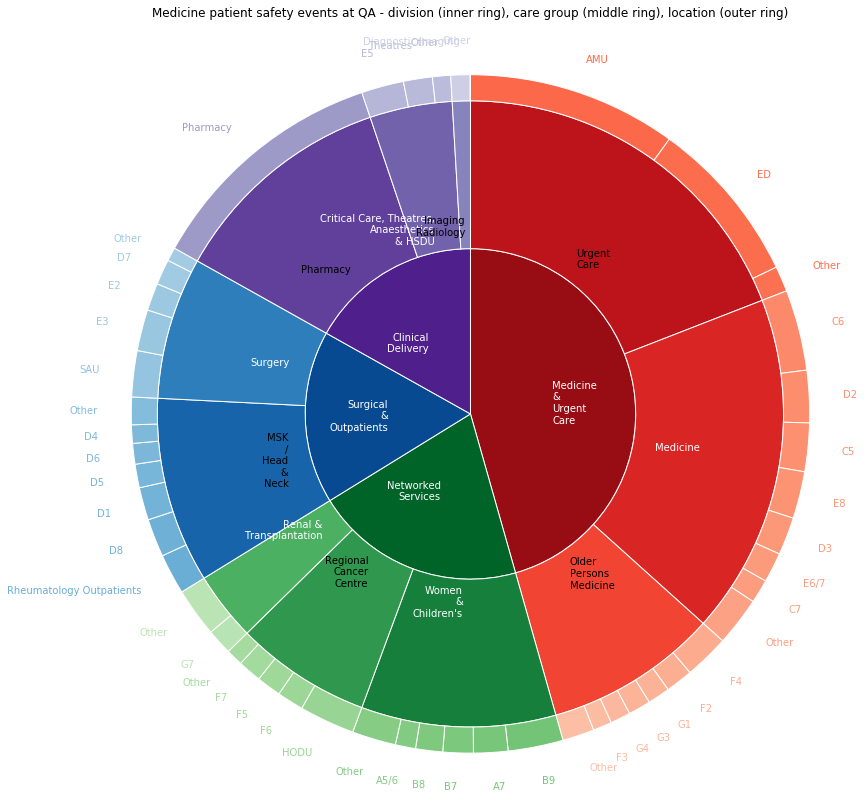

In [18]:
# Create colors
a, b, c, d, e =[plt.cm.Reds, plt.cm.Oranges, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]
a, c, d, e = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]
inner_ring_colours = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]

# First Ring (Inside)
fig, ax = plt.subplots()
ax.axis('equal')
division_labels_newlines = [i.replace(' ','\n') for i in division_labels]
#mypie, _ = ax.pie(division_counts, radius=2, labels=division_labels_newlines, labeldistance=0.6, colors=[a(0.9), b(0.9), c(0.9), d(0.9), e(0.9)], textprops={'color':'w'})
mypie, _ = ax.pie(division_counts, radius=1.9, labels=division_labels_newlines, labeldistance=0.5, colors=[a(0.9), c(0.9), d(0.9), e(0.9)], textprops={'color':'w'}, startangle=90, counterclock=False)
plt.setp( mypie, width=1.9, edgecolor='white')
 
# Second Ring (oUTside)
care_group_labels_newlines = [i.replace(' ','\n') for i in care_group_labels]
care_group_labels_newlines[care_group_labels_newlines.index('Renal\n&\nTransplantation')] = 'Renal &\nTransplantation'
care_group_labels_newlines[care_group_labels_newlines.index('Critical\nCare,\nTheatres,\nAnaesthetics\n&\nHSDU')] = 'Critical Care, Theatres,\nAnaesthetics\n& HSDU'
#care_group_labels_newlines[care_group_labels_newlines.index('Imaging\nRadiology')] = 'Imaging Radiology'
#care_group_colours = [a(0.8), a(0.7), a(0.6), a(0.5), b(0.8), c(0.8), c(0.7), c(0.6), d(0.8), d(0.7), d(0.6), e(0.8), e(0.7), e(0.6)]
care_group_colours = [a(0.8), a(0.7), a(0.6), c(0.8), c(0.7), c(0.6), d(0.8), d(0.7), d(0.6), e(0.8), e(0.7), e(0.6)]
care_group_colours = []
for i,index in enumerate(division_counts.index):
    df_division = df[df.division == index]
    per_division_counts = df_division['care_group'].value_counts()
    slice_colour = 8
    for j in range(len(per_division_counts)):
        care_group_colours.append(inner_ring_colours[i](slice_colour/10))
        slice_colour -= 1
mypie2, texts = ax.pie(care_group_counts, radius=3.6, labels=care_group_labels_newlines, labeldistance=0.6, colors=care_group_colours, textprops={'color':'k'},startangle=90, counterclock=False)
plt.setp( mypie2, width=1.7, edgecolor='white')
care_group_label_colours = ['k' if i%2==0 else 'w' for i in range(len(care_group_counts))]
for text, color in zip(texts, care_group_label_colours):
    text.set_color(color)
plt.margins(0,0)

# Third Ring (oUTside)
location_colours = [a(0.5),a(0.49),a(0.48),a(0.47),a(0.4),a(0.39),a(0.38),a(0.37),a(0.36),a(0.35),a(0.34),a(0.33),a(0.32),a(0.31),a(0.30),a(0.29),a(0.28),a(0.27),a(0.26),a(0.25),a(0.24),c(0.50),c(0.49),c(0.48),c(0.47),c(0.46),c(0.45),c(0.40),c(0.39),c(0.38),c(0.37),c(0.36),c(0.30),c(0.29),c(0.28),c(0.27),d(0.50),d(0.40),d(0.39),d(0.38),d(0.37),d(0.30),e(0.50),e(0.49),e(0.48),e(0.47),e(0.46),e(0.45),e(0.44),e(0.40),e(0.39),e(0.38),e(0.37)]
location_colours = []
for i,div_index in enumerate(division_counts.index):
    df_division = df[df.division == div_index]
    slice_colour_orig = 0.5
    division_care_group_counts = df_division['care_group'].value_counts()[df_division['care_group'].unique()]
    for j,care_index in enumerate(division_care_group_counts.index):
        df_care_group = df_division[df_division['care_group-location'].str.startswith(care_index)]
        per_care_group_counts = df_care_group['care_group-location'].value_counts()[df_care_group['care_group-location'].unique()]
        slice_colour = slice_colour_orig - j/10
        for k in per_care_group_counts:
            location_colours.append(inner_ring_colours[i](slice_colour))
            slice_colour -= 0.01
mypie3, texts = ax.pie(location_counts, radius=3.9, labels=location_labels, colors=location_colours, startangle=90, counterclock=False)
plt.setp( mypie3, width=0.3, edgecolor='white')
for text, color in zip(texts, location_colours):
    text.set_color(color)
plt.margins(0,0)

plt.title('Medicine patient safety events at QA - division (inner ring), care group (middle ring), location (outer ring)', y=2.3);